<a href="https://colab.research.google.com/github/AliAkbarBadri/topics-for-types/blob/main/topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
! pip -q install laserembeddings
! python -m laserembeddings download-models
! pip -q install transformers

     |████████████████████████████████| 51kB 3.8MB/s 
     |████████████████████████████████| 860kB 7.2MB/s 

✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fcodes    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fvocab    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/bilstm.93langs.2018-12-26.pt    

✨ You're all set!
     |████████████████████████████████| 1.3MB 5.4MB/s 
     |████████████████████████████████| 1.1MB 52.3MB/s 
     |████████████████████████████████| 2.9MB 54.0MB/s 


In [17]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoConfig, AutoTokenizer, AutoModel
from laserembeddings import Laser
from __future__ import unicode_literals

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LASER

In [4]:
laser = Laser()

In [107]:
df_topics_laser = pd.read_csv("/content/drive/My Drive/topics-for-types/df_topics.csv")
df_topics_laser.head()

,sentence,اقتصاد,بازی,برنامه‌نویسی,تحصیل,تغذیه,حقوق/قانون,حیوانات,خرید,روابط,روانشناسی,زبان,زیبایی,سرگرمی,سفر,سلامت,فنی,ماشین,مذهبی,ورزش,کار,کامپیوتر/موبایل,کودکان,گیاهان
0,تفاوت ترمز عقب دیسکی و کاسه ای چیست؟,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
1,آیا ترمز ضدقفل ABS در همه چرخ ها عمل می کند؟,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,چرا باوجود نصب بودن ترمز ABS بر روی خودرو، ترم...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,چرا با وجود نصب بودن Airbag بر روی خودرو، در ه...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,کلاس های مختلف خودرو چگونه شناسایی می شوند؟,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0


In [108]:
n_class = len(df_topics_laser.columns.values)-1
n_class

23

In [109]:
df_topics_laser['sentence'] = df_topics_laser['sentence'].apply(lambda sent: laser.embed_sentences(sent, lang='fa')[0])
df_topics_laser.head()

,sentence,اقتصاد,بازی,برنامه‌نویسی,تحصیل,تغذیه,حقوق/قانون,حیوانات,خرید,روابط,روانشناسی,زبان,زیبایی,سرگرمی,سفر,سلامت,فنی,ماشین,مذهبی,ورزش,کار,کامپیوتر/موبایل,کودکان,گیاهان
0,"[0.020942228, -8.114154e-05, -0.0009854127, 0....",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
1,"[0.008679963, 0.0027223488, -0.000162347, 0.01...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,"[0.011158587, 0.01838572, -8.3516294e-05, 0.01...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,"[0.00957515, 0.013646437, 7.700363e-05, 0.0117...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,"[0.027029112, 0.0024084542, 0.0004833732, 0.00...",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0


In [110]:
X = np.array(df_topics_laser[df_topics_laser.columns[0]])
X = np.vstack(X)

Y = df_topics_laser[df_topics_laser.columns[1:]].values

X.shape, Y.shape

((2708, 1024), (2708, 23))

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)

In [112]:
len(X_train),len(X_test),len(y_train),len(y_test)

(2437, 271, 2437, 271)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X[0].shape, name='input_layer'),
    # tf.keras.layers.Dense(32, activation='relu', name='Dense_Layer0'),
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout0"),
    tf.keras.layers.Dense(128, activation='selu', name='Dense_Layer1'),
                          # activity_regularizer=tf.keras.regularizers.l2()),
    
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout1"),
    # tf.keras.layers.Dense(32, activation='relu', name='Dense_Layer2'),
                          # activity_regularizer=tf.keras.regularizers.l2()),
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout2"),
    tf.keras.layers.Dense(n_class, activation='sigmoid', name='Dense_Layer3'),

  ], name='BERT_MODEL')


In [115]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X[0].shape, name='input_layer'),
    tf.keras.layers.Dense(128, activation='selu', name='Dense_Layer1'),
    tf.keras.layers.Dense(n_class, activation='sigmoid', name='Output'),
  ], name='LASER_Model')

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['acc',
                       tfa.metrics.f_scores.F1Score(n_class,'weighted', threshold=0.5, name='f1'),
                       tfa.metrics.f_scores.F1Score(n_class,'macro',threshold=0.5, name='macro'),
                       tfa.metrics.f_scores.F1Score(n_class,'micro',threshold=0.5, name='micro'),
                       tfa.metrics.HammingLoss(mode='multilabel',threshold=0.5, name='hamloss')])
print(model.summary())

Model: "LASER_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Layer1 (Dense)         (None, 128)               131200    
_________________________________________________________________
Output (Dense)               (None, 23)                2967      
Total params: 134,167
Trainable params: 134,167
Non-trainable params: 0
_________________________________________________________________
None


In [116]:
history = model.fit(X_train, y_train, batch_size=4, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
488/488 [==============================] - 3s 5ms/step - loss: 0.2689 - acc: 0.2032 - f1: 0.0525 - macro: 0.0219 - micro: 0.0554 - hamloss: 0.0860 - val_loss: 0.2299 - val_acc: 0.3033 - val_f1: 0.0990 - val_macro: 0.0510 - val_micro: 0.1203 - val_hamloss: 0.0808
Epoch 2/20
488/488 [==============================] - 2s 5ms/step - loss: 0.2009 - acc: 0.3145 - f1: 0.2623 - macro: 0.1240 - micro: 0.3159 - hamloss: 0.0729 - val_loss: 0.1882 - val_acc: 0.3381 - val_f1: 0.3319 - val_macro: 0.1781 - val_micro: 0.4040 - val_hamloss: 0.0686
Epoch 3/20
488/488 [==============================] - 2s 5ms/step - loss: 0.1652 - acc: 0.3787 - f1: 0.4413 - macro: 0.2618 - micro: 0.5005 - hamloss: 0.0619 - val_loss: 0.1655 - val_acc: 0.4160 - val_f1: 0.4491 - val_macro: 0.2825 - val_micro: 0.4946 - val_hamloss: 0.0621
Epoch 4/20
488/488 [==============================] - 2s 5ms/step - loss: 0.1444 - acc: 0.4295 - f1: 0.5617 - macro: 0.3845 - micro: 0.6004 - hamloss: 0.0537 - val_loss: 0.1531 -

In [117]:
score = model.evaluate(X_test, y_test, verbose=1)

9/9 [==============================] - 0s 4ms/step - loss: 0.1271 - acc: 0.4502 - f1: 0.7098 - macro: 0.6390 - micro: 0.7165 - hamloss: 0.0444


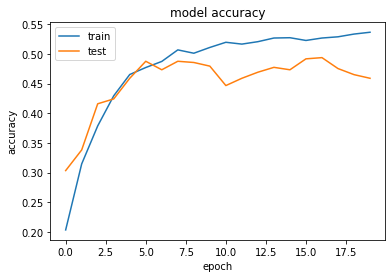

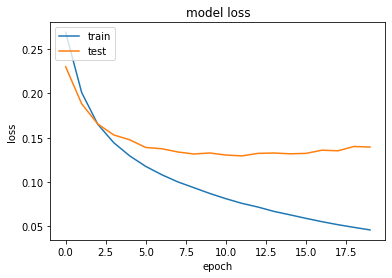

In [118]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# BERT

In [29]:
config = AutoConfig.from_pretrained("m3hrdadfi/albert-fa-base-v2")
tokenizer = AutoTokenizer.from_pretrained("m3hrdadfi/albert-fa-base-v2")
bert_model = AutoModel.from_pretrained("m3hrdadfi/albert-fa-base-v2")

In [30]:
def get_embedding(sent):
    input_sentence = torch.tensor(tokenizer.encode(sent, max_length = 500)).unsqueeze(0)
    out = bert_model(input_sentence)
    embeddings_of_last_layer = out[0]
    cls_embeddings = embeddings_of_last_layer[0][0]
    cls_embeddings = cls_embeddings.detach().numpy()
    return cls_embeddings

In [31]:
df_topics_bert = pd.read_csv("/content/drive/My Drive/topics-for-types/df_topics.csv")

In [32]:
df_topics_bert['sentence'] = df_topics_bert['sentence'].apply(lambda sent: get_embedding(sent))
df_topics_bert.to_csv("/content/drive/My Drive/topics-for-types/df_topics_bert.csv", index=False)
df_topics_bert.head()

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


,sentence,اقتصاد,بازی,برنامه‌نویسی,تحصیل,تغذیه,حقوق/قانون,حیوانات,خرید,روابط,روانشناسی,زبان,زیبایی,سرگرمی,سفر,سلامت,فنی,ماشین,مذهبی,ورزش,کار,کامپیوتر/موبایل,کودکان,گیاهان
0,"[-0.5841074, -0.017078003, -0.32405344, -0.645...",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
1,"[-0.31120673, -0.0050979797, 0.10509731, -0.36...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,"[0.05544515, -0.23301096, 0.12021764, -0.33959...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,"[0.37881416, -0.1909234, 0.16427912, -0.383240...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,"[-0.46968994, -0.2401005, 0.20189604, -0.20498...",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0


In [33]:
df_topics_bert = pd.read_csv("/content/drive/My Drive/topics-for-types/df_topics_bert.csv")
df_topics_bert['sentence'] = df_topics_bert['sentence'].apply(lambda x: 
                           np.fromstring(
                               x.replace('\n','')
                                .replace('[','')
                                .replace(']','')
                                .replace('  ',' '), sep=' '))
df_topics_bert.head()

,sentence,اقتصاد,بازی,برنامه‌نویسی,تحصیل,تغذیه,حقوق/قانون,حیوانات,خرید,روابط,روانشناسی,زبان,زیبایی,سرگرمی,سفر,سلامت,فنی,ماشین,مذهبی,ورزش,کار,کامپیوتر/موبایل,کودکان,گیاهان
0,"[-0.584107399, -0.0170780029, -0.324053437, -0...",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
1,"[-0.311206728, -0.00509797968, 0.105097309, -0...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,"[0.0554451495, -0.233010963, 0.120217644, -0.3...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,"[0.378814161, -0.190923393, 0.164279118, -0.38...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,"[-0.469689935, -0.240100503, 0.201896042, -0.2...",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0


In [34]:
X = np.array(df_topics_bert[df_topics_bert.columns[0]])
X = np.vstack(X)

Y = df_topics_bert[df_topics_bert.columns[1:]].values

X.shape, Y.shape

((2708, 768), (2708, 23))

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)

In [68]:
len(X_train),len(X_test),len(y_train),len(y_test)

(2437, 271, 2437, 271)

In [104]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X[0].shape, name='input_layer'),
    # tf.keras.layers.Dense(32, activation='relu', name='Dense_Layer0'),
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout0"),
    tf.keras.layers.Dense(128, activation='selu', name='Dense_Layer1'),
                          # activity_regularizer=tf.keras.regularizers.l2()),
    
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout1"),
    # tf.keras.layers.Dense(32, activation='relu', name='Dense_Layer2'),
                          # activity_regularizer=tf.keras.regularizers.l2()),
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout2"),
    tf.keras.layers.Dense(n_class, activation='sigmoid', name='Dense_Layer3'),

  ], name='BERT_MODEL')

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['acc',
                       tfa.metrics.f_scores.F1Score(n_class,'weighted', threshold=0.5, name='f1'),
                       tfa.metrics.f_scores.F1Score(n_class,'macro',threshold=0.5, name='macro'),
                       tfa.metrics.f_scores.F1Score(n_class,'micro',threshold=0.5, name='micro'),
                       tfa.metrics.HammingLoss(mode='multilabel',threshold=0.5, name='hamloss')])
print(model.summary())

Model: "BERT_MODEL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Layer1 (Dense)         (None, 128)               98432     
_________________________________________________________________
Dense_Layer3 (Dense)         (None, 23)                2967      
Total params: 101,399
Trainable params: 101,399
Non-trainable params: 0
_________________________________________________________________
None


In [105]:
history = model.fit(X_train, y_train, batch_size=4, epochs=20, verbose=1, validation_split=0.1)

Epoch 1/20
549/549 [==============================] - 3s 5ms/step - loss: 0.2112 - acc: 0.3174 - f1: 0.3706 - macro: 0.2131 - micro: 0.4069 - hamloss: 0.0738 - val_loss: 0.1841 - val_acc: 0.3115 - val_f1: 0.4854 - val_macro: 0.3115 - val_micro: 0.5490 - val_hamloss: 0.0615
Epoch 2/20
549/549 [==============================] - 2s 4ms/step - loss: 0.1588 - acc: 0.4104 - f1: 0.5611 - macro: 0.3852 - micro: 0.5908 - hamloss: 0.0580 - val_loss: 0.1730 - val_acc: 0.3811 - val_f1: 0.5213 - val_macro: 0.3746 - val_micro: 0.5718 - val_hamloss: 0.0633
Epoch 3/20
549/549 [==============================] - 2s 4ms/step - loss: 0.1391 - acc: 0.4359 - f1: 0.6297 - macro: 0.5009 - micro: 0.6480 - hamloss: 0.0522 - val_loss: 0.1663 - val_acc: 0.3402 - val_f1: 0.5359 - val_macro: 0.3919 - val_micro: 0.5902 - val_hamloss: 0.0599
Epoch 4/20
549/549 [==============================] - 2s 4ms/step - loss: 0.1270 - acc: 0.4583 - f1: 0.6803 - macro: 0.5608 - micro: 0.6930 - hamloss: 0.0466 - val_loss: 0.1669 -

In [106]:
score = model.evaluate(X_test, y_test, verbose=1)

9/9 [==============================] - 0s 4ms/step - loss: 0.1778 - acc: 0.4244 - f1: 0.6766 - macro: 0.5890 - micro: 0.6861 - hamloss: 0.0485


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Word2Vec

In [ ]:
df_topics_lstm = pd.read_csv("/content/drive/My Drive/topics-for-types/df_topics.csv")
df_topics_lstm.head()

In [ ]:
X = df_topics_lstm[df_topics_lstm.columns[0]].values
Y = df_topics_lstm[df_topics_lstm.columns[1:]].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)

In [ ]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
vocab_size, X_train.shape, y_train.shape, X_test.shape, y_test.shape

(8612, (2181, 200), (2181, 12), (243, 200), (243, 12))

In [ ]:
embeddings_dictionary = dict()

glove_file = open('drive/My Drive/nlp/similarity/embeddings/twitt_wiki_ham_blog.fa.text.100.vec', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(maxlen,)),
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim = 100, 
                            weights=[embedding_matrix],
                            trainable=False, name='Embedding_Layer'),
    tf.keras.layers.LSTM(200,
                        # return_sequences=True,
                        # stateful=True,
                        recurrent_initializer='glorot_uniform',
                        name='LSTM_Layer'),
    tf.keras.layers.Dense(12, activation='sigmoid', name='Dense_Layer')
  ], name='LSTM_Model')
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['acc'])
print(model.summary())
print()
print(model.layers[0].weights)

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=15, verbose=1, validation_split=0.2)

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])